In [1]:
!pip install sagemaker --upgrade huggingface-hub diffusers torch transformers hf_transfer huggingface-hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 108.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 38.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 89.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 191.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 166.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 26.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 140.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 153.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 132.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1

In [6]:
!mkdir code

In [16]:
import os
import boto3
import tarfile
import tempfile
import subprocess
import sagemaker

sagemaker_session = sagemaker.Session()

[03/09/25 03:06:28] INFO     Found credentials from IAM Role:                                   ]8;id=826252;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=747934;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [3]:
import huggingface_hub
import os
hf_token = os.environ.get('HF_TOKEN')
if hf_token:
    huggingface_hub.login(token=hf_token)

In [1]:
from pathlib import Path
import os
 
# set HF_HUB_ENABLE_HF_TRANSFER env var to enable hf-transfer for faster downloads
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
 
HF_MODEL_ID = "black-forest-labs/flux-dev"
# create model dir
model_tar_dir = Path(HF_MODEL_ID.split("/")[-1])
model_tar_dir.mkdir(exist_ok=True)

In [2]:
!wget -P {model_tar_dir} https://huggingface.co/Comfy-Org/flux1-dev/resolve/main/flux1-dev-fp8.safetensors

--2025-03-09 02:56:55--  https://huggingface.co/Comfy-Org/flux1-dev/resolve/main/flux1-dev-fp8.safetensors
Resolving huggingface.co (huggingface.co)... 3.167.112.96, 3.167.112.45, 3.167.112.25, ...
connected. to huggingface.co (huggingface.co)|3.167.112.96|:443... 
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/55/c7/55c73edb17ac436d7eb50ec6765ae882a2b99221eb1c8643fae0277ebacff2e6/8e91b68084b53a7fc44ed2a3756d821e355ac1a7b6fe29be760c1db532f3d88a?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27flux1-dev-fp8.safetensors%3B+filename%3D%22flux1-dev-fp8.safetensors%22%3B&Expires=1741492250&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0MTQ5MjI1MH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zLzU1L2M3LzU1YzczZWRiMTdhYzQzNmQ3ZWI1MGVjNjc2NWFlODgyYTJiOTkyMjFlYjFjODY0M2ZhZTAyNzdlYmFjZmYyZTYvOGU5MWI2ODA4NGI1M2E3ZmM0NGVkMmEzNzU2ZDgyMWUzNTVhYzFhN2I2ZmUyOWJlNzYwYzFkYjUzMmYzZDg4YT9yZX

In [3]:
import os
os.path.getsize(f'{model_tar_dir}/flux1-dev-fp8.safetensors')

17246524772

In [4]:
import torch
from diffusers import FluxPipeline

pipe = FluxPipeline.from_single_file(
    f'{model_tar_dir}/flux1-dev-fp8.safetensors',
    torch_dtype=torch.bfloat16,
    cache_dir=model_tar_dir,
    local_dir_use_symlinks=False,
    low_cpu_mem_usage=True,
)

model_index.json:   0%|          | 0.00/536 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/378 [00:00<?, ?B/s]

(…)ion_pytorch_model.safetensors.index.json:   0%|          | 0.00/121k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/820 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Some weights of the model checkpoint were not used when initializing CLIPTextModel: 
 ['text_projection.weight']


KeyboardInterrupt: 

In [7]:
%%writefile code/requirements.txt
diffusers==0.32.2
transformers==4.49.0
accelerate>=0.21.0
safetensors>=0.4.0
pillow>=10.0.0
protobuf
sentencepiece

Writing code/requirements.txt


In [8]:
%%writefile code/inference.py
import os
import io
import json
import base64
import torch
import gc
import logging
from diffusers import FluxPipeline
import huggingface_hub

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("flux_inference")

# Setup a file handler to write logs to a file in /tmp
file_handler = logging.FileHandler('/tmp/inference_logs.log')
file_handler.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

def model_fn(model_dir):
    """
    Load the model from the model directory.
    This function is called by SageMaker when the container starts.
    """
    hf_token = os.environ.get('HF_TOKEN')
    if hf_token:
        huggingface_hub.login(token=hf_token)

    # Load the model using from_pretrained instead of from_single_file
    pipe = FluxPipeline.from_single_file(
        f'{model_dir}/flux1-dev-fp8.safetensors',
        local_files_only=True
    )
    
    # Enable CPU offload for memory optimization
    pipe.enable_sequential_cpu_offload()
    
    return pipe

def input_fn(request_body, request_content_type):
    """
    Parse input data from the request.
    """
    logger.info(f"input_fn called with content_type: {request_content_type}")
    logger.info(f"request_body type: {type(request_body)}")
    
    if isinstance(request_body, bytearray) or isinstance(request_body, bytes):
        logger.info(f"request_body is bytes-like, first 100 chars: {request_body[:100]}")
    else:
        logger.info(f"request_body is not bytes-like, type: {type(request_body)}")
    
    if request_content_type == 'application/json':
        # Parse JSON input
        logger.info("Processing JSON input")
        if isinstance(request_body, bytearray) or isinstance(request_body, bytes):
            logger.info("Converting bytearray/bytes to string")
            request_body = request_body.decode('utf-8')
            logger.info(f"Decoded request_body: {request_body[:100]}...")
            
        try:
            input_data = json.loads(request_body)
            logger.info(f"Parsed JSON input: {input_data}")
        except Exception as e:
            logger.error(f"Error parsing JSON: {e}")
            raise
        
        # Handle different input formats:
        # If input is in {inputs: ..., parameters: ...} format
        if "inputs" in input_data and "parameters" in input_data:
            logger.info("Found inputs/parameters format")
            # Extract prompt from inputs
            prompt = input_data["inputs"]
            logger.info(f"Prompt type: {type(prompt)}, value: {prompt}")
            
            if isinstance(prompt, bytearray) or isinstance(prompt, bytes):
                logger.info("Converting prompt from bytearray/bytes to string")
                prompt = prompt.decode('utf-8')
                
            # Create a new input dictionary with the prompt and parameters
            result = {
                "prompt": prompt,
                **input_data["parameters"]
            }
            logger.info(f"Returning combined input data: {result}")
            return result
            
        # Otherwise, use the input data directly
        logger.info(f"Using direct input format: {input_data}")
        return input_data
    else:
        # Default case - treat as plain text prompt
        logger.info("Non-JSON content type, treating as plain text")
        if isinstance(request_body, bytearray) or isinstance(request_body, bytes):
            logger.info("Converting plain text from bytearray/bytes to string")
            request_body = request_body.decode('utf-8')
        result = {"prompt": request_body}
        logger.info(f"Returning prompt dict: {result}")
        gc.collect()
        torch.cuda.empty_cache()
        return result

def predict_fn(input_data, model):
    """
    Generate the image based on the input prompt.
    """
    logger.info("predict_fn called")
    logger.info(f"Input data: {input_data}")
    
    pipe = model
    
    # Extract parameters from the input with defaults
    prompt = input_data.get("prompt", "a beautiful landscape")
    logger.info(f"Extracted prompt: {prompt} (type: {type(prompt)})")
    
    # Ensure prompt is a string
    if isinstance(prompt, bytearray) or isinstance(prompt, bytes):
        logger.info("Converting prompt from bytearray/bytes to string")
        prompt = prompt.decode('utf-8')
        logger.info(f"Converted prompt: {prompt}")
        
    guidance_scale = float(input_data.get("guidance_scale", 3.5))
    height = int(input_data.get("height", 768))
    width = int(input_data.get("width", 1360))
    num_inference_steps = int(input_data.get("num_inference_steps", 3))
    
    logger.info(f"Parameters: guidance_scale={guidance_scale}, height={height}, width={width}, steps={num_inference_steps}")
    
    # Additional optional parameters
    negative_prompt = input_data.get("negative_prompt", None)
    logger.info(f"Negative prompt: {negative_prompt} (type: {type(negative_prompt) if negative_prompt else None})")
    
    if negative_prompt is not None and (isinstance(negative_prompt, bytearray) or isinstance(negative_prompt, bytes)):
        logger.info("Converting negative_prompt from bytearray/bytes to string")
        negative_prompt = negative_prompt.decode('utf-8')
        
    seed = input_data.get("seed", None)
    logger.info(f"Seed: {seed}")
    
    # Set seed if provided
    generator = None
    if seed is not None:
        logger.info(f"Setting generator with seed: {seed}")
        generator = torch.Generator().manual_seed(int(seed))
    
    # Generate the image
    logger.info("Calling Flux pipeline")
    try:
        output = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            guidance_scale=guidance_scale,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            generator=generator,
        )
        logger.info("Image generation successful")
    except Exception as e:
        logger.error(f"Error generating image: {e}")
        raise
    
    # Get the first image (assuming batch size of 1)
    image = output.images[0]
    logger.info(f"Image dimensions: {image.width}x{image.height}")
    
    # Convert to base64 string
    try:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        logger.info(f"Base64 encoded image length: {len(img_str)}")
    except Exception as e:
        logger.error(f"Error encoding image: {e}")
        raise
    
    # Return the image and metadata
    result = {
        "image": img_str,
        "parameters": {
            "prompt": prompt,
            "guidance_scale": guidance_scale,
            "height": height,
            "width": width,
            "steps": num_inference_steps,
            "seed": seed
        }
    }
    logger.info("Returning result with image and parameters")
    return result

def output_fn(prediction, response_content_type):
    """Format the prediction output."""
    logger.info(f"output_fn called with content_type: {response_content_type}")
    logger.info(f"Prediction contains image: {'image' in prediction}")
    
    if response_content_type == 'application/json':
        logger.info("Returning JSON response")
        try:
            json_result = json.dumps(prediction)
            logger.info(f"JSON response length: {len(json_result)}")
            return json_result, response_content_type
        except Exception as e:
            logger.error(f"Error serializing to JSON: {e}")
            raise
    else:
        # Return just the base64 image for non-JSON requests
        logger.info("Returning plain text response (image only)")
        return prediction["image"], "text/plain"

Writing code/inference.py


In [9]:
import shutil

# Move the file
shutil.move('code', 'flux-dev/code')

'flux-dev/code'

In [11]:
import os
import shutil
import tarfile

# Create a clean directory structure
clean_dir = 'clean-flux'
code_dir = os.path.join(clean_dir, 'code')
os.makedirs(clean_dir, exist_ok=True)
os.makedirs(code_dir, exist_ok=True)

# Copy code files
shutil.copy2('flux-dev/code/inference.py', os.path.join(code_dir, 'inference.py'))
shutil.copy2('flux-dev/code/requirements.txt', os.path.join(code_dir, 'requirements.txt'))

# Copy the main model file
shutil.copy2('flux-dev/flux1-dev-fp8.safetensors', os.path.join(clean_dir, 'flux1-dev-fp8.safetensors'))

# Source directories
source_dir = 'flux-dev/models--black-forest-labs--FLUX.1-dev'
snapshot_dir = os.path.join(source_dir, 'snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44')

# Copy model components, resolving symlinks
for component in ['text_encoder', 'text_encoder_2', 'tokenizer', 'tokenizer_2', 'transformer', 'vae', 'scheduler']:
    # Create component directory
    component_dir = os.path.join(clean_dir, component)
    os.makedirs(component_dir, exist_ok=True)
    
    # Source component directory
    src_component = os.path.join(snapshot_dir, component)
    
    # Copy files, resolving symlinks
    if os.path.exists(src_component):
        for file in os.listdir(src_component):
            src_file = os.path.join(src_component, file)
            dst_file = os.path.join(component_dir, file)
            
            if os.path.islink(src_file):
                # Get the actual file the symlink points to
                real_path = os.path.realpath(src_file)
                if os.path.exists(real_path):
                    shutil.copy2(real_path, dst_file)
                    print(f"Resolved symlink: {src_file} -> {real_path} -> {dst_file}")
                else:
                    print(f"Warning: Broken symlink: {src_file} -> {real_path}")
            else:
                shutil.copy2(src_file, dst_file)
                print(f"Copied file: {src_file} -> {dst_file}")

# Copy model index file
model_index_src = os.path.join(snapshot_dir, 'model_index.json')
if os.path.islink(model_index_src):
    real_path = os.path.realpath(model_index_src)
    if os.path.exists(real_path):
        shutil.copy2(real_path, os.path.join(clean_dir, 'model_index.json'))
        print(f"Resolved symlink for model_index.json")

Resolved symlink: flux-dev/models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/text_encoder/config.json -> /home/ec2-user/SageMaker/flux-dev/models--black-forest-labs--FLUX.1-dev/blobs/5ebd923ce51522c605f64ab3d26ea024672777b6 -> clean-flux/text_encoder/config.json
Resolved symlink: flux-dev/models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/text_encoder_2/model.safetensors.index.json -> /home/ec2-user/SageMaker/flux-dev/models--black-forest-labs--FLUX.1-dev/blobs/c8728bc3dca59d2616a2a594cbac3ddb9eb77d5b -> clean-flux/text_encoder_2/model.safetensors.index.json
Resolved symlink: flux-dev/models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/text_encoder_2/config.json -> /home/ec2-user/SageMaker/flux-dev/models--black-forest-labs--FLUX.1-dev/blobs/b00a8a6908682a2091f1194b81f220fd2b67c41c -> clean-flux/text_encoder_2/config.json
Resolved symlink: flux-dev/models--black-forest-labs

In [23]:
# Ensure all model files/folders are in model directory and moved to model_tar_dir
# Ensure all model files/folders are in model directory and moved to model_tar_dir
import shutil
os.mkdir("models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/")

# move each dir within clean_flux to the new directory
for dir in os.listdir("clean_flux"):
    shutil.move(os.path.join("clean_flux", dir), "models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/")

In [13]:
import os
import shutil

# Set directory paths
parent_dir = os.getcwd()

# Change to model dir
os.chdir(str('clean-flux'))
print(f"Changed directory to {os.getcwd()}")

# Use pigz for faster and parallel compression
!tar -cf model.tar.gz --use-compress-program=pigz *
print("Created model.tar.gz with pigz")

# Move the tarball to the parent directory if needed
shutil.move("model.tar.gz", f"{parent_dir}/model.tar.gz")
print(f"Moved model.tar.gz to {parent_dir}")

# Change back to parent dir
os.chdir(parent_dir)

Changed directory to /home/ec2-user/SageMaker/clean-flux
Created model.tar.gz with pigz
Moved model.tar.gz to /home/ec2-user/SageMaker


In [14]:
# inspect contents to ensure no symlinks
!tar -tvf model.tar.gz

drwxrwxr-x ec2-user/ec2-user 0 2025-03-09 02:59 code/
-rw-rw-r-- ec2-user/ec2-user 7954 2025-03-09 02:59 code/inference.py
-rw-rw-r-- ec2-user/ec2-user  115 2025-03-09 02:59 code/requirements.txt
-rw-rw-r-- ec2-user/ec2-user 17246524772 2024-08-03 20:16 flux1-dev-fp8.safetensors
drwxrwxr-x ec2-user/ec2-user           0 2025-03-09 03:01 models--black-forest-labs--FLUX.1-dev/
drwxrwxr-x ec2-user/ec2-user           0 2025-03-09 03:02 models--black-forest-labs--FLUX.1-dev/snapshots/
drwxrwxr-x ec2-user/ec2-user           0 2025-03-09 03:01 models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/
drwxrwxr-x ec2-user/ec2-user           0 2025-03-09 02:59 models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/text_encoder/
-rw-rw-r-- ec2-user/ec2-user         613 2025-03-09 02:58 models--black-forest-labs--FLUX.1-dev/snapshots/0ef5fff789c832c5c7f4e127f94c8b54bbcced44/text_encoder/config.json
drwxrwxr-x ec2-user/ec2-user       

In [17]:
from sagemaker.s3 import S3Uploader
from pathlib import Path

# upload model.tar.gz to s3
s3_model_uri = S3Uploader.upload(local_path=Path("model.tar.gz"), desired_s3_uri=f"s3://{sagemaker_session.default_bucket()}/flux-cpu-offload")

print(f"model uploaded to: {s3_model_uri}")

[03/09/25 03:06:35] INFO     Found credentials from IAM Role:                                   ]8;id=729352;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=996902;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

model uploaded to: s3://sagemaker-us-east-1-200256637908/flux-cpu-offload/model.tar.gz


In [18]:
import os
import boto3
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

# Get SageMaker execution role
role = get_execution_role()
session = sagemaker.Session()

# Configuration parameters
model_name = "flux-image-generator"
hf_token = os.environ.get("HF_TOKEN")
instance_type = "ml.g5.8xlarge"
s3_model_uri = s3_model_uri

# Create PyTorch model with custom inference code
model = PyTorchModel(
    model_data=s3_model_uri,
    role=role,
    # entry_point="code/inference.py",
    # source_dir="./code",  # Directory with inference.py and requirements.txt
    framework_version="2.5",
    py_version="py311",   # Must match Python version of your custom wheels
    env={
        "HF_TOKEN": hf_token,
        "HF_USECASE": "text-to-image"
    }
)

[03/09/25 03:07:43] INFO     Found credentials from IAM Role:                                   ]8;id=413734;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=558041;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=614883;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=220873;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [19]:
# Deploy the model to an endpoint
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=f"{model_name}-endpoint"
)

print(f"Model deployed successfully to endpoint: {predictor.endpoint_name}")

[03/09/25 03:07:44] INFO     Found credentials from IAM Role:                                   ]8;id=845336;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=381124;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Creating model with name: pytorch-inference-2025-03-09-03-07-44-409    ]8;id=774826;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=750188;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

[03/09/25 03:07:45] INFO     Creating endpoint-config with name flux-image-generator-endpoint       ]8;id=255355;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=849692;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#5937\5937]8;;\

                    INFO     Creating endpoint with name flux-image-generator-endpoint              ]8;id=392826;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=565348;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4759\4759]8;;\

---------!Model deployed successfully to endpoint: flux-image-generator-endpoint


In [22]:
# Use the boto3 runtime client directly for more control
import boto3
import json

# Create runtime client
runtime = boto3.client('runtime.sagemaker')

# Create a simplified payload - just a string prompt
payload = json.dumps({"prompt": "a tiny astronaut hatching from an egg on the moon"})

# Make the direct call
response = runtime.invoke_endpoint(
    EndpointName="flux-image-generator-endpoint",
    ContentType="application/json",
    Body=payload
)

response

{'ResponseMetadata': {'RequestId': 'b07e0b6f-3cb9-4836-82e2-a9b4390447b9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b07e0b6f-3cb9-4836-82e2-a9b4390447b9',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Sun, 09 Mar 2025 03:21:30 GMT',
   'content-type': 'application/json',
   'content-length': '1464247',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7f5c7d813e80>}

[03/09/25 03:22:33] INFO     generated new fontManager                                         ]8;id=702932;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=86867;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

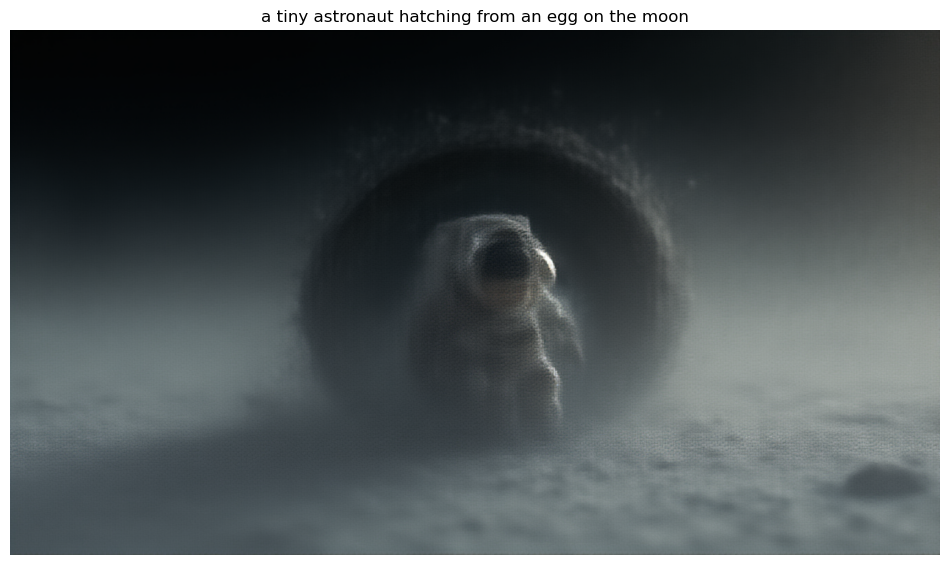

Image saved to generated_image.png
Parameters used:
- prompt: a tiny astronaut hatching from an egg on the moon
- guidance_scale: 3.5
- height: 768
- width: 1360
- steps: 3
- seed: None


In [23]:
import base64
import io
import json
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'response' is the variable containing the response object you showed
def display_sagemaker_image(response):
    # Read the streaming body content
    response_body = response['Body'].read()
    
    # Parse the JSON content
    json_response = json.loads(response_body)
    
    # Extract the base64-encoded image
    base64_img = json_response["image"]
    
    # Decode the base64 string
    img_bytes = base64.b64decode(base64_img)
    
    # Create a BytesIO object from the decoded bytes
    img_buffer = io.BytesIO(img_bytes)
    
    # Open the image using PIL
    img = Image.open(img_buffer)
    
    # Display the image using matplotlib
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    
    # Display the prompt if available
    if "parameters" in json_response and "prompt" in json_response["parameters"]:
        plt.title(json_response["parameters"]["prompt"])
    
    plt.show()
    
    # Optionally save the image
    img.save("generated_image.png")
    print(f"Image saved to generated_image.png")
    
    # Print parameters if available
    if "parameters" in json_response:
        print("Parameters used:")
        for key, value in json_response["parameters"].items():
            print(f"- {key}: {value}")
    
    return img

# Use the function with your response
image = display_sagemaker_image(response)